In [1]:
import numpy as np 
data_path1 = "/Users/waelbenslima/Desktop/data/phitwo1.txt"
data1 = np.loadtxt(data_path1)
data_reshaped1 = data1.reshape((1331, 171, 171))
data_path3 = "/Users/waelbenslima/Desktop/data/power1.txt"
data3 = np.loadtxt(data_path3)
data_reshaped3 = data3.reshape((1331, 171, 171))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

# Load data
phi2 = data_reshaped1.reshape((1331, 171, 171, 1))  # Shape: (1331, 171, 171, 1) (phi2)
power = data_reshaped3.reshape((1331, 171, 171, 1))  # Shape: (1331, 171, 171, 1) (Power)

# Normalize data
phi2_norm = phi2 / np.max(phi2)
power_norm = power / np.max(power)

# Define function to generate random masks with sparsity
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Define function to add noise
def add_noise(data, sigma):
    # Add noise: (1 + u(0, sigma)) * data
    noise = np.random.normal(0, sigma, data.shape)
    noisy_data = data * (1 + noise)
    return noisy_data

# Apply masks to phi2 data
sparsity = 0.8
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Add noise with different sigma values
sigma_values = [0.01, 0.2, 0.5]
noisy_phi2 = {}

for sigma in sigma_values:
    print(f"Adding noise with sigma = {sigma}")
    noisy_phi2[sigma] = add_noise(phi2_masked, sigma)

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, power_norm, masks, test_size=0.2, random_state=42
)

# Define the CNN model for reconstruction of power from masked phi2
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction of power
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()


Adding noise with sigma = 0.01
Adding noise with sigma = 0.2
Adding noise with sigma = 0.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ phi2_input          │ (None, 171, 171,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 171, 171,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 171, 171,  │          0 │ phi2_input[0][0], │
│                     │ 1)                │            │ mask_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 171, 171,  │        320 │ multiply[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 86, 86,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 86, 86,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 43, 43,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 43, 43,    │     36,928 │ max_pooling2d_1[… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 86, 86,    │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 86, 86,    │     18,464 │ up_sampling2d[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 172, 172,  │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 172, 172,  │        289 │ up_sampling2d_1[… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d          │ (None, 171, 171,  │          0 │ conv2d_2[0][0]    │
│ (Cropping2D)        │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

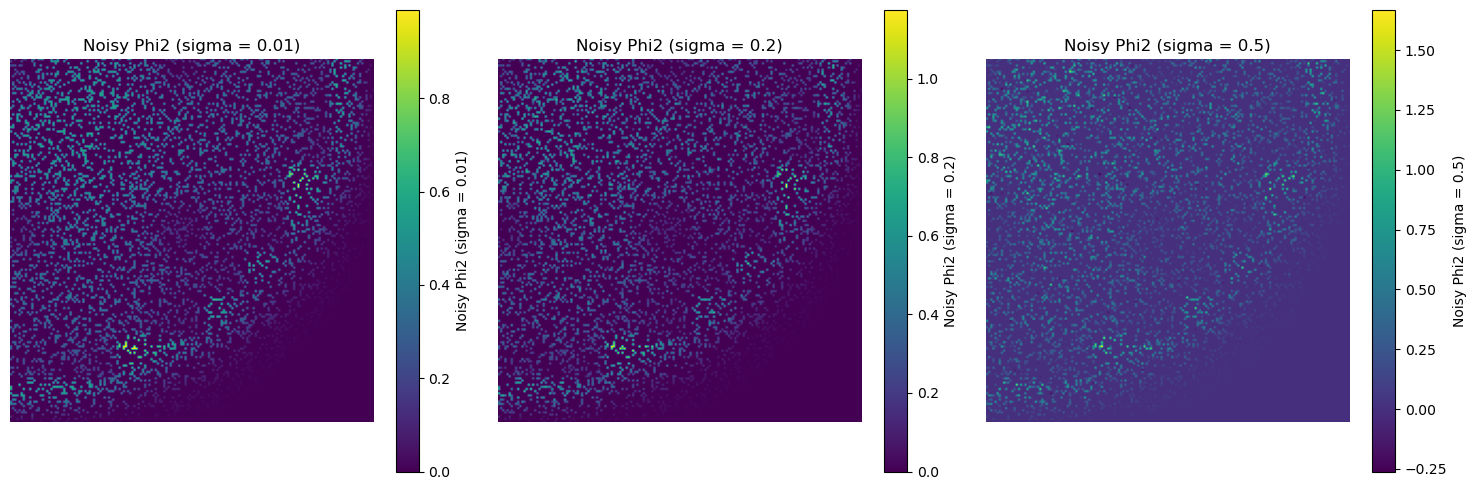

In [5]:
# Visualize noisy phi2 data for different sigma values

n_samples = 3  # Number of samples to display

# Create subplots for noisy Phi2 for different sigma values
plt.figure(figsize=(15, 5))

for i, sigma in enumerate(sigma_values):
    plt.subplot(1, len(sigma_values), i + 1)
    plt.imshow(noisy_phi2[sigma][0].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label=f'Noisy Phi2 (sigma = {sigma})')
    plt.title(f'Noisy Phi2 (sigma = {sigma})')
    plt.axis('off')

plt.tight_layout()
plt.show()


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 580ms/step - loss: 0.0865 - val_loss: 0.0218
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 571ms/step - loss: 0.0202 - val_loss: 0.0186
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 606ms/step - loss: 0.0155 - val_loss: 0.0111
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 665ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 791ms/step - loss: 0.0073 - val_loss: 0.0046
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 694ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 740ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 734ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 647ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 616ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 723ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23

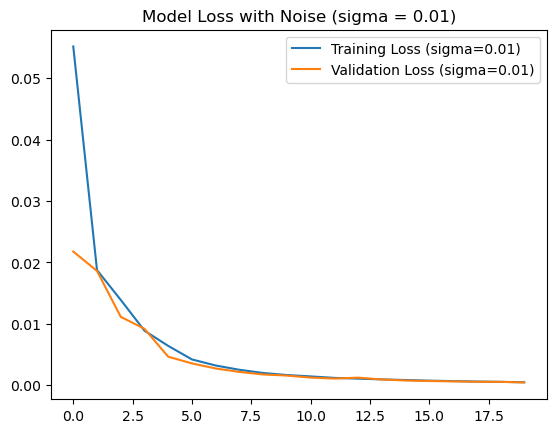

In [7]:
# Add noise with sigma = 0.01 to phi2 data
sigma = 0.01
noisy_phi2_001 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_001, X_test_001, y_train_001, y_test_001, masks_train_001, masks_test_001 = train_test_split(
    noisy_phi2_001, power_norm, masks, test_size=0.2, random_state=42  # Use power_norm as target
)

# Train the model with noisy phi2 and the original power as target
history_001 = model.fit(
    [X_train_001, masks_train_001], y_train_001,
    validation_data=([X_test_001, masks_test_001], y_test_001),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_001.history['loss'], label='Training Loss (sigma=0.01)')
plt.plot(history_001.history['val_loss'], label='Validation Loss (sigma=0.01)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.01)")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


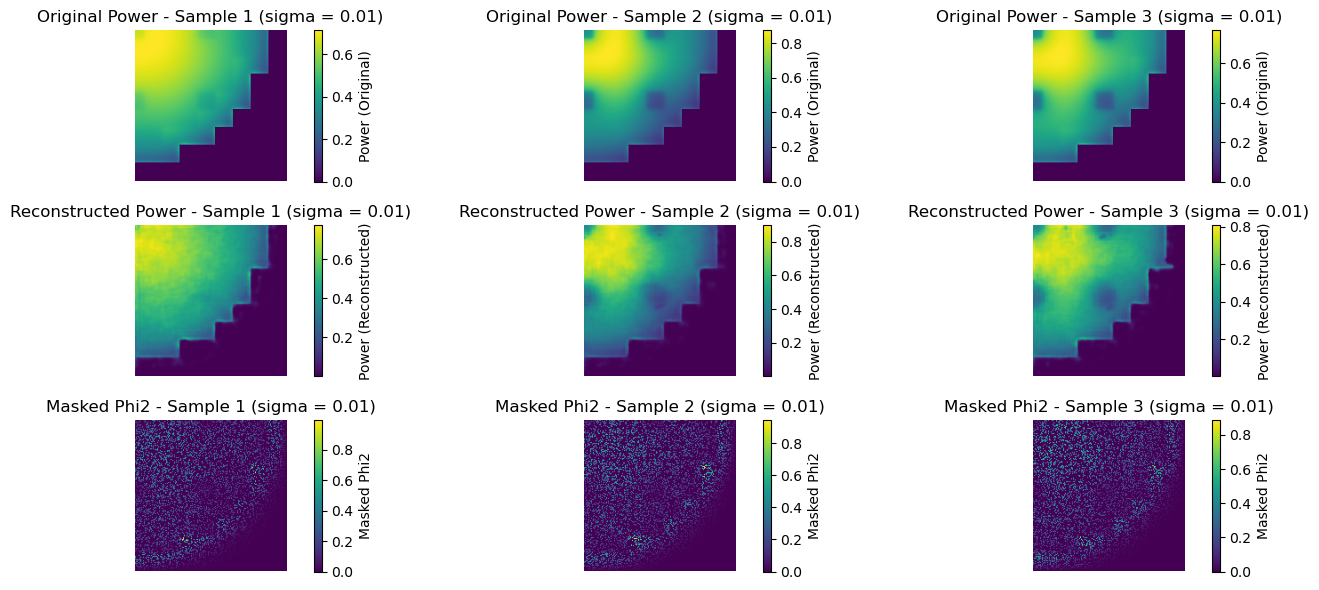

In [9]:
# Predict the output for the noisy input (sigma = 0.01)
predicted_power_001 = model.predict([X_test_001, masks_test_001])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Power (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test_001[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Power (Original)')
    plt.title(f'Original Power - Sample {i+1} (sigma = 0.01)')
    plt.axis('off')

    # Reconstructed Power (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_power_001[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Power (Reconstructed)')
    plt.title(f'Reconstructed Power - Sample {i+1} (sigma = 0.01)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(noisy_phi2_001[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sigma = 0.01)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Predict the output for the noisy input (sigma = 0.01)
predicted_power_001 = model.predict([X_test_001, masks_test_001])

# Flatten the images for metric calculations
y_true_flat = y_test_001.flatten()  # True power values (y_test_001)
y_pred_flat = predicted_power_001.flatten()  # Predicted power values (predicted_power_001)

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test_001[0].reshape(171, 171), predicted_power_001[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sigma = 0.01
print(f"Sigma = 0.01:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")  # Added percentage format
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Sigma = 0.01:
RMSE: 0.020815002084501624
L∞ Error: 0.556326687335968
SSIM: 0.9066343674955394
L2 Error: 58.160509151528636
Relative L2 Error: 5.01%
--------------------------------------------------


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 603ms/step - loss: 0.0101 - val_loss: 0.0012
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 590ms/step - loss: 8.4937e-04 - val_loss: 5.7699e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 557ms/step - loss: 5.3602e-04 - val_loss: 4.5593e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 561ms/step - loss: 4.3113e-04 - val_loss: 3.9483e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 3.7978e-04 - val_loss: 3.6608e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 556ms/step - loss: 3.5136e-04 - val_loss: 3.4321e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 556ms/step - loss: 3.3000e-04 - val_loss: 3.2710e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 558ms/step - loss: 3.1646e-04 - val_loss: 3.1052e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 565ms/step - loss: 3.0268e-04 - val_loss: 2.9829e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 553ms/step - loss: 2.8788e-04 - val_loss: 2.9337e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 559ms/step - l

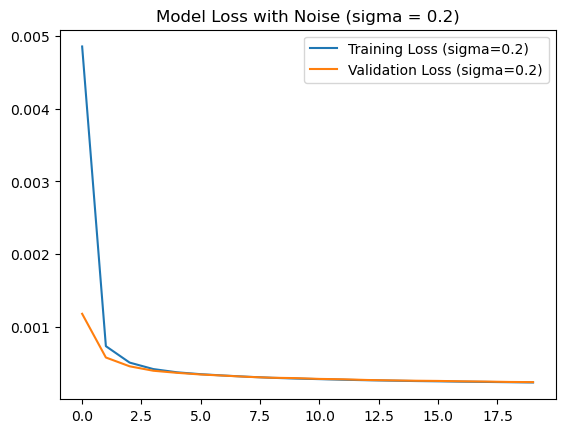

In [13]:
# Add noise with sigma = 0.2 to phi2 data
sigma = 0.2
noisy_phi2_002 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_002, X_test_002, y_train_002, y_test_002, masks_train_002, masks_test_002 = train_test_split(
    noisy_phi2_002, phi2_norm, masks, test_size=0.2, random_state=42  # Use phi2_norm as target
)

# Train the model with noisy phi2 and the original phi2 as target
history_002 = model.fit(
    [X_train_002, masks_train_002], y_train_002,
    validation_data=([X_test_002, masks_test_002], y_test_002),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_002.history['loss'], label='Training Loss (sigma=0.2)')
plt.plot(history_002.history['val_loss'], label='Validation Loss (sigma=0.2)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.2)")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


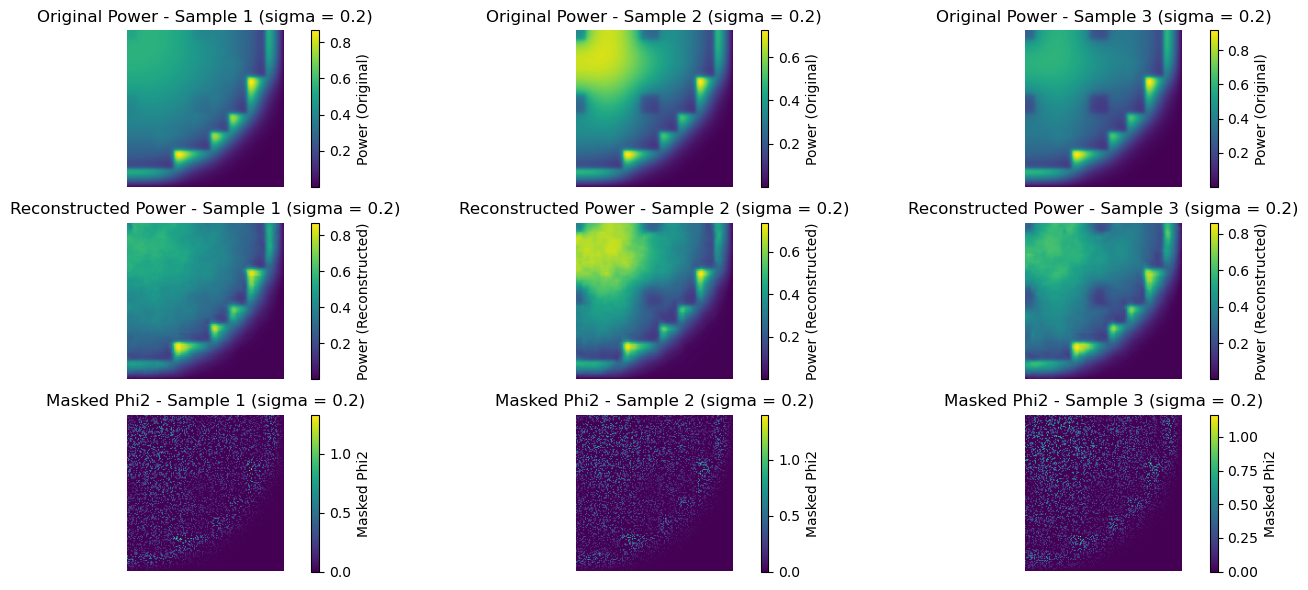

In [15]:
# Predict the output for the noisy input (sigma = 0.2)
predicted_power_002 = model.predict([X_test_002, masks_test_002])

# Visualize results for sigma = 0.2
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Power (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Power (Original)')
    plt.title(f'Original Power - Sample {i+1} (sigma = 0.2)')
    plt.axis('off')

    # Reconstructed Power (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_power_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Power (Reconstructed)')
    plt.title(f'Reconstructed Power - Sample {i+1} (sigma = 0.2)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(noisy_phi2_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sigma = 0.2)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
# Predict the output for the noisy input (sigma = 0.2)
predicted_power_002 = model.predict([X_test_002, masks_test_002])

# Flatten the images for metric calculations
y_true_flat_002 = y_test_002.flatten()  # True power values (y_test_002)
y_pred_flat_002 = predicted_power_002.flatten()  # Predicted power values (predicted_power_002)

# 1. Calculate RMSE (Root Mean Squared Error)
rmse_002 = np.sqrt(mean_squared_error(y_true_flat_002, y_pred_flat_002))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error_002 = np.max(np.abs(y_true_flat_002 - y_pred_flat_002))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index_002 = ssim(y_test_002[0].reshape(171, 171), predicted_power_002[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error_002 = np.linalg.norm(y_true_flat_002 - y_pred_flat_002)

# 5. Calculate Relative L2 Error
true_l2_norm_002 = np.linalg.norm(y_true_flat_002)
relative_l2_error_002 = (l2_error_002 / true_l2_norm_002) * 100  # Convert to percentage

# Print the results for sigma = 0.2
print(f"Sigma = 0.2:")
print(f"RMSE: {rmse_002}")
print(f"L∞ Error: {l_inf_error_002}")
print(f"SSIM: {ssim_index_002}")
print(f"L2 Error: {l2_error_002}")
print(f"Relative L2 Error: {relative_l2_error_002:.2f}%")
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
Sigma = 0.2:
RMSE: 0.015432304540141028
L∞ Error: 0.25184066696522067
SSIM: 0.9613861192927227
L2 Error: 43.120374708220396
Relative L2 Error: 4.36%
--------------------------------------------------


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 633ms/step - loss: 0.0025 - val_loss: 8.4717e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 565ms/step - loss: 7.6342e-04 - val_loss: 6.8650e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 559ms/step - loss: 6.6519e-04 - val_loss: 6.5316e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 625ms/step - loss: 6.4251e-04 - val_loss: 6.3704e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 654ms/step - loss: 6.2951e-04 - val_loss: 6.3515e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 561ms/step - loss: 6.2174e-04 - val_loss: 6.2150e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 555ms/step - loss: 6.1306e-04 - val_loss: 6.1434e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 560ms/step - loss: 6.0283e-04 - val_loss: 6.1552e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 549ms/step - loss: 6.0111e-04 - val_loss: 6.0350e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 572ms/step - loss: 6.0223e-04 - val_loss: 5.9588e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 550ms/step

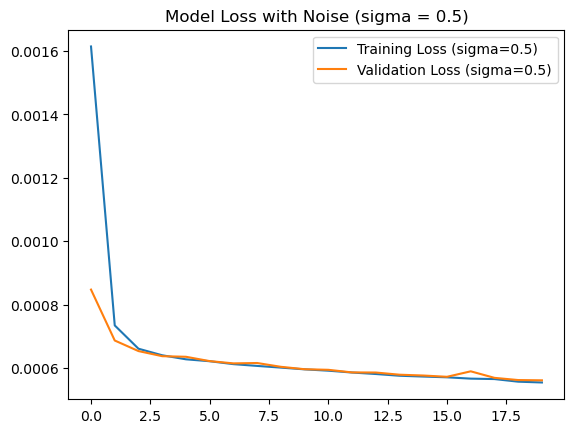

In [19]:
# Add noise with sigma = 0.5 to phi2 data
sigma = 0.5
noisy_phi2_005 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_005, X_test_005, y_train_005, y_test_005, masks_train_005, masks_test_005 = train_test_split(
    noisy_phi2_005, phi2_norm, masks, test_size=0.2, random_state=42  # Use phi2_norm as target
)

# Train the model with noisy phi2 and the original phi2 as target
history_005 = model.fit(
    [X_train_005, masks_train_005], y_train_005,
    validation_data=([X_test_005, masks_test_005], y_test_005),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_005.history['loss'], label='Training Loss (sigma=0.5)')
plt.plot(history_005.history['val_loss'], label='Validation Loss (sigma=0.5)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.5)")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


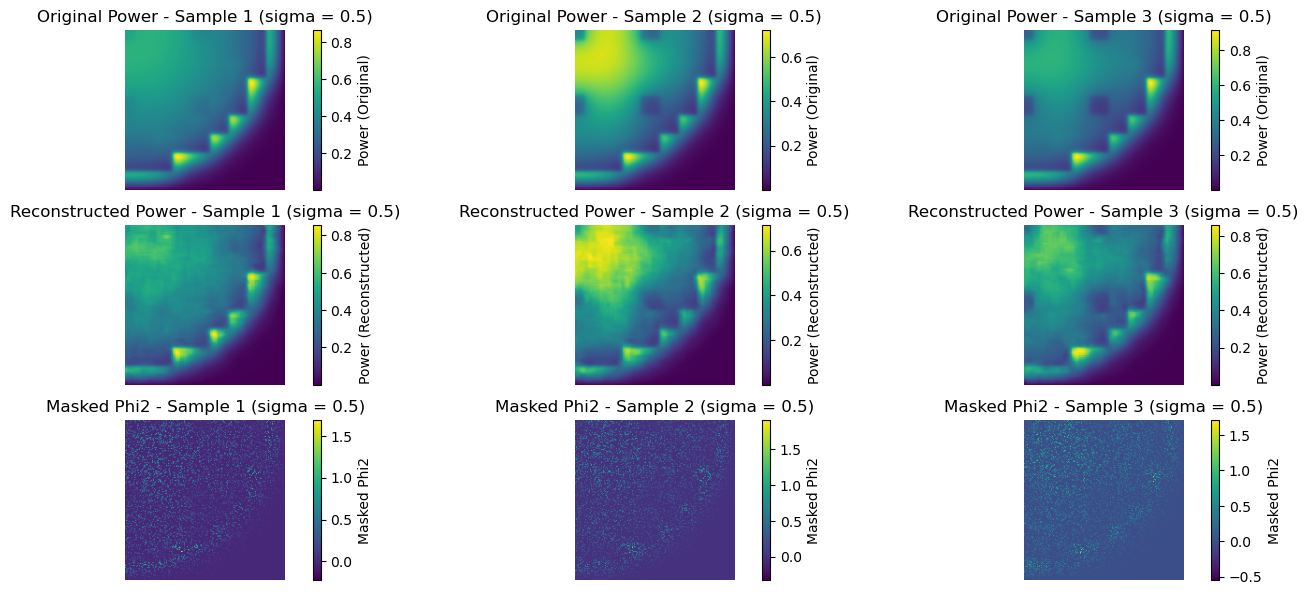

In [21]:
# Predict the output for the noisy input (sigma = 0.5)
predicted_power_005 = model.predict([X_test_005, masks_test_005])

# Visualize results for sigma = 0.5
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Power (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Power (Original)')
    plt.title(f'Original Power - Sample {i+1} (sigma = 0.5)')
    plt.axis('off')

    # Reconstructed Power (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_power_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Power (Reconstructed)')
    plt.title(f'Reconstructed Power - Sample {i+1} (sigma = 0.5)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(noisy_phi2_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sigma = 0.5)')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Predict the output for the noisy input (sigma = 0.5)
predicted_power_005 = model.predict([X_test_005, masks_test_005])

# Flatten the images for metric calculations
y_true_flat_005 = y_test_005.flatten()  # True power values (y_test_005)
y_pred_flat_005 = predicted_power_005.flatten()  # Predicted power values (predicted_power_005)

# 1. Calculate RMSE (Root Mean Squared Error)
rmse_005 = np.sqrt(mean_squared_error(y_true_flat_005, y_pred_flat_005))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error_005 = np.max(np.abs(y_true_flat_005 - y_pred_flat_005))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index_005 = ssim(y_test_005[0].reshape(171, 171), predicted_power_005[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error_005 = np.linalg.norm(y_true_flat_005 - y_pred_flat_005)

# 5. Calculate Relative L2 Error
true_l2_norm_005 = np.linalg.norm(y_true_flat_005)
relative_l2_error_005 = (l2_error_005 / true_l2_norm_005) * 100  # Convert to percentage

# Print the results for sigma = 0.5
print(f"Sigma = 0.5:")
print(f"RMSE: {rmse_005}")
print(f"L∞ Error: {l_inf_error_005}")
print(f"SSIM: {ssim_index_005}")
print(f"L2 Error: {l2_error_005}")
print(f"Relative L2 Error: {relative_l2_error_005:.2f}%")
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Sigma = 0.5:
RMSE: 0.02368267860151155
L∞ Error: 0.345226991610754
SSIM: 0.9304531434023753
L2 Error: 66.17326483775093
Relative L2 Error: 6.70%
--------------------------------------------------
